# Getting Started

This notebook gets you started with a brief nDCG evaluation with LensKit for Python.

This notebook is also available on [Google Collaboratory](https://colab.research.google.com/drive/1ym040cKkQf85epu80VtIkMXy3LpfYQky?usp=sharing) and [nbviewer](https://nbviewer.jupyter.org/github/lenskit/lkpy/blob/master/doc/GettingStarted.ipynb).

## Setup

We first import the LensKit components we need:

In [ ]:
from lenskit.batch import recommend
from lenskit.metrics import RunAnalysis, NDCG, RBP, RecipRank
from lenskit.splitting import crossfold_users, SampleFrac
from lenskit.als import BiasedMF
from lenskit.knn import ItemKNNScorer 
from lenskit.data import load_movielens, ItemListCollection, UserIDKey
from lenskit.pipeline import topn_pipeline

And Pandas is very useful, as is Seaborn for plotting:

In [12]:
import pandas as pd
import seaborn as sns

The `pyprojroot` package makes it easy to find input data:

In [3]:
from pyprojroot.here import here

## Loading Data

We're going to use the ML-100K data set:

In [4]:
ml100k = load_movielens(here('data/ml-100k.zip'))
ml100k.interaction_log('pandas', original_ids=True).head()

,user_id,item_id,rating,timestamp
0,1,1,5.0,874965758
1,1,2,3.0,876893171
2,1,3,4.0,878542960
3,1,4,3.0,876893119
4,1,5,3.0,889751712


## Defining Recommenders

Let's set up two scoring models:

In [5]:
model_ii = ItemKNNScorer(20)
model_als = BiasedMF(50)

For each of these, we also need to make a :ref:`pipeline <pipeline>`:

In [6]:
pipe_ii = topn_pipeline(model_ii)
pipe_als = topn_pipeline(model_als)

## Running the Evaluation

In LensKit, our evaluation proceeds in 2 steps:

1. Generate recommendations
2. Measure them

If memory is a concern, we can measure while generating, but we will not do that for now.

Let's start by creating and collecting the recommendations; we will collect all of them into a single `ItemListCollection`:

In [7]:
all_test = ItemListCollection(UserIDKey)
ii_recs = ItemListCollection(UserIDKey)
als_recs = ItemListCollection(UserIDKey)

for split in crossfold_users(ml100k, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)
    
    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_als = pipe_als.clone()
    fit_als.train(split.train)
    # generate recs
    als_recs.add_from(recommend(fit_als, split.test.keys(), 100))

    # do the same for item-item
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs.add_from(recommend(fit_ii, split.test.keys(), 100))

/Users/mde48/LensKit/lkpy/lenskit/lenskit/als/_explicit.py:91: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1728232278409/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  rmat = rmat.to_sparse_csr()
/Users/mde48/LensKit/lkpy/lenskit/lenskit/pipeline/types.py:149: TypecheckWarning: cannot type-check object of type <class 'numpy.int32'> against generic
  warnings.warn(
/Users/mde48/LensKit/lkpy/lenskit/lenskit/pipeline/types.py:149: TypecheckWarning: cannot type-check object of type <class 'numpy.int32'> against generic
  warnings.warn(
/Users/mde48/LensKit/lkpy/lenskit/lenskit/pipeline/types.py:149: TypecheckWarning: cannot type-check object of type <class 'numpy.int32'> against generic
  warnings.warn(
/Users/mde48/LensKit/lkpy/lenskit/lenskit/pipeline/types.py:149: Typec

## Measuring Recommendations

We analyze our recommendation lists with a `RunAnalysis` and some metrics.

In [8]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
als_results = ran.compute(als_recs, all_test)
ii_results = ran.compute(ii_recs, all_test)
ii_results.list_summary()

,mean,median,std
metric,,,
NDCG,0.094840,7.227523e-02,0.091161
RBP,0.035599,1.490116e-08,0.117246
RecipRank,0.107921,3.846154e-02,0.189325


Now we have nDCG values!  We can combine results together to make combined charts.

In [9]:
all_list_metrics = pd.concat({
    'ALS': als_results.list_metrics(),
    'IKNN': ii_results.list_metrics(),
}, names=['Model'])
all_list_metrics.groupby('Model').mean()

,NDCG,RBP,RecipRank
Model,,,
ALS,0.128488,0.091866,0.201931
IKNN,0.094840,0.035599,0.107921


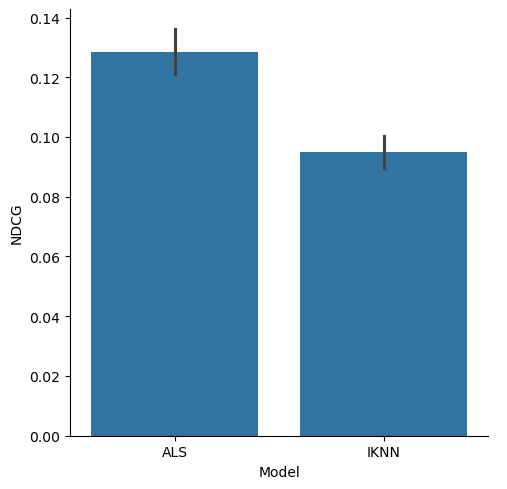

In [16]:
sns.catplot(all_list_metrics.reset_index(), x='Model', y='NDCG', kind='bar')